# Web-scraping Poe's poems and performing emotional analysis

**Introduction**

The theme of this project is the emotional analysis of Edgar Allan Poe's poems. The dataset has been obtained at https://www.gutenberg.org/files/10031/10031-h/10031-h.htm through web-scraping techniques using the BeautifulSoup package. It is a dictionary of where each poem title is a key, and its text is the value. No manual editing was done on the data; all of the process to locate it, acquire it and format it is done via Python code shown further down in the notebook.

The three main tools used to perform the emotional analysis of the poems is NLTK's Punkt tokenizer (https://www.nltk.org/_modules/nltk/tokenize/punkt.html), Vader's Sentiment Analyzer (https://github.com/cjhutto/vaderSentiment), and the DepecheMood's emotional lexicon (https://arxiv.org/abs/1405.1605).

For the tokenizer, no further work is done, as this is a library that is simply imported, and the relevant methods called. It was used to split the poems into stanzas, and then further into words, tagging each of them to be able to identify whether they are being used as adjectives, adverbs, nouns or verbs.

Vader's Sentiment Analyzer produces three scores: 'positive', 'neutral' and 'negative', normalized to a total of 1, and then a fourth, 'compound', which is a compound value calculated from the three before that can range from 1 (positive sentiment) to -1 (negative sentiment). For the purpose of my analysis, I decided to drop the first three values and work only with the resulting compound, as it shows in a single number whether the work is positive, neutral or negative. The Sentiment Analyzer is run directly on the stanzas without further tokenizing, as Vader's analyzer is particularly good at picking up the context of words. Then, the result of every stanza is taken into account to calculate a mean of the compound score, showing the overall sentiment of the poem. The same process is repeated to calculate the sentiment of the entire corpus of poems as a whole.

DepecheMood's emotional lexicon was manually downloaded into the data folder, and although no modifications have been made to it, the words extracted from the poems are checked for their semantic type and have a final suffix added to them to be able to match them to the lexicon: #a for adjective, #n for noun, #r for adverb and #v for verb. The words it contains are assigned a percentile value (normalized to a total of 1) in 8 different emotions: Afraid, Amused, Angry, Annoyed, Don't Care, Happy, Inspired and Sad. The scores of each word of each poem are added together to create poem-wide values, and then again to create global values.

Besides each percentile value of emotions, each individual word is assigned a single one of the 8 emotions, checking which one has the highest score, so as to allow us to determine whether a poem contains significantly more words of one emotion or another. This provides a much more visual set of data, as it will polarize the results and clearly show us which emotions dominate the texts.

The final results are all contained within the JSON files within the directory, as well as displayed in the notebook through structured print statements and, at the end, a chat created programmatically to display the global stats (so-called Zeitgeist). 

The expectation when this project began was that, for the most part, the majority of the poems would contain a lot of Don't Care, Sad, or Afraid, as these are things that the author is famous for. However, perhaps due to the format being poetry (which is particularly difficult to decipher even for humans, let alone lexicons), the overwhelming emotion in the entire corpus of poems as a whole is Inspired, with 2684 words out of 7488 emotional words found. Far behind, but in second and third position, are Sad (1026) and Amused (928), respectively.

Although these results diverge from the expectation, Happy is nonetheless the least found emotion of all, with a mere 358 words out of the total, which barely represents a 5%. As far as the sentiment goes, it was expected that it would be leaning towards negative values, given that Poe is known for being a Gothic author, but the final result scores a 17.8% positive sentiment. If we browse through the individual results of each poem, this can be attributed to the many love poems dedicated to women throughout his life, most of which have notably positive sentiments (some, like the famous Annabel Lee, go as high as 66% compound positive sentiment!).

Below is the code for every part of this analysis, including the web-scraping. It should not need any special setup. All cells should be run from first to last. The first execution will probably take longer than normal due to downloading NLTK's resources.

### Imports required:

In [1]:

# For web-scraping
from bs4 import BeautifulSoup
from bs4 import NavigableString
import requests
from urllib.request import urlopen

# For natural language analysis and tokenizing
import re
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# Data handling
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt

# Time
import time


### Helper functions

In [2]:
# Get current time in milliseconds
def get_ms_now():
    return int(round(time.time() * 1000))
        

# Dictionary helpers
def add_dictionaries(base_dict, added_dict):
    for key in added_dict:
            if (key not in base_dict):
                base_dict[key] = 0
            
            base_dict[key] += added_dict[key]
            
            
def get_max_key(numDict):
    if (len(numDict) <= 0):
        return ""
    
    return max(numDict, key=numDict.get)


def increment_key_count(base_dict, keyFound):
    if (keyFound not in base_dict):
        return 1

    else:
        return base_dict[keyFound] + 1
        
        
def normalize_dictionary(dictionary):
    sum_of_values = sum(dictionary.values())
    
    for key in dictionary:
        dictionary[key] = dictionary[key] / sum_of_values
        
    return dictionary


def get_percentile_dict(dictionary):
    percent_dict = {}
    for key, value in dictionary.items():
        percent_dict[key] = str('%.2f'%(value * 100)) + "%"
        
    return percent_dict
        

# Web-scraping helper
# Filters only the string contents inside a tag, without including children tags
def filter_string_contents(tag):
    string_contents = ""
    
    if isinstance(tag, NavigableString):
        return tag.strip()
        
    contents = tag.contents
    filtered = filter(lambda x: isinstance(x, str), contents)

    for string in filtered:
        string_contents += string + "\n"
    
    return string_contents


# JSON writer
# Write the data into a JSON file
def write_JSON(data, path):
    
    # The 'with' keyword creates a context handler that will automatically close the file
    # once we are done working with it, to prevent us forgetting from doing this:
    # https://cmdlinetips.com/2016/01/opening-a-file-in-python-using-with-statement/
    with open(path, "w", encoding="utf-8") as file:
        
        # json.dump() converts a python object to JSON data ready to be written into a file
        # not to be confused with json.dumps(): https://www.geeksforgeeks.org/json-dump-in-python/
        json.dump(data, file, ensure_ascii=False, indent=2)
        
        
# Write the data into a JSON file
def read_JSON(path):
    
    # The 'with' keyword creates a context handler that will automatically close the file
    # once we are done working with it, to prevent us forgetting from doing this:
    # https://cmdlinetips.com/2016/01/opening-a-file-in-python-using-with-statement/
    with open(path) as file:
        
        # json.dump() converts a python object to JSON data ready to be written into a file
        # not to be confused with json.dumps(): https://www.geeksforgeeks.org/json-dump-in-python/
        return json.load(file)

### Web-scraping

In [3]:
# We will use this timestamp to measure the total execution time at the end of the notebook
total_elapsed_ms = get_ms_now()

# The scraped poems will be stored here
poem_dict = {}

# Open a request to the URL
html_page = urlopen("https://www.gutenberg.org/files/10031/10031-h/10031-h.htm")
soup = BeautifulSoup(html_page, "lxml")

# Move our current search to section2c, right before the poems are found in the HTML data
poem_section_start = soup.find("a", attrs = {"name":"section2c"})

# This tag will be out iterator
tag = poem_section_start

while (tag != None):
    
    # Skip anything but headers not titled 'Note on', as they are not poems, but notes on them
    if (tag.name != "h3" or tag.string == None or "Note on" in tag.string):
        tag = tag.find_next_sibling()
        continue

    # Get the poem title and create the dict entry
    poem_title = tag.string
    poem_dict[poem_title] = ""
    next_tag = tag.find_next()

    # While the next non-NavigableString tag is not the end of the current poem...
    while(next_tag != None):
        
        # Break at any <p> we find; these are not poems anymore, but end of poem content like note references
        if (next_tag.name == "p"):
            break
          
        # Break at any <a> that is named section, note, or fXX, as these indicate new sections or footers after the poem
        if (next_tag.name == "a" and 
            "name" in next_tag.attrs and 
            re.search('^(section)|(note)|(f\\d)', next_tag.attrs["name"]) != None
           ):
            break
        
        # ...find the next NavigableString and add it to our poem
        tag = tag.find_next(text=True)
        poem_dict[poem_title] += tag.strip() + "\n"
        
        # Update the next tag so we can check our loop condition and make sure we aren't past the poem's end
        next_tag = tag.find_next()


    # Move on to the next poem by finding the next <a> section tag
    tag = tag.find_next(lambda t: t.name == "a" and "name" in t.attrs and re.search('^section\\d\\w$', t.attrs["name"]) != None)

    # This is the end of the poems; after this section there are essays which we won't analyze
    if (tag != None and tag.attrs["name"] == "section8a"):
        print("END")
        break
            
    tag = tag.find_next()


END


### Save scraped data as JSON

In [4]:
write_JSON(poem_dict, "scraped_poems.json")

### Tokenization functions

In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def tokenize_sentences(text):
    # This gives us a list of sentences
    return nltk.sent_tokenize(text)

def tokenize_words(text):
    # This gives us a list of words
    tokenized_text = nltk.word_tokenize(text)
    return tokenized_text
    
def tag_words_in_sentence(tokenized_text):
    tagged = nltk.pos_tag(tokenized_text)
    return tagged

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MistZ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MistZ\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Compile our Emotional Lexicon (DepecheMood)

In [6]:
# We will be using DepecheMood's Emotion Lexicon for this task, which can be found at https://github.com/marcoguerini/DepecheMood
# The /data folder already contains the csv file of the lexicon that we will be using

# DepecheMood lexicon's contains a tag at the end of each word to indicate what type they are, 
# separated from the word with a #:

# '#a': adjective
# '#n': noun
# '#r': adverb
# '#v': verb

# Initialize Emotional Lexicon
lexicon = {}

# Compile the DepecheMood emotion lexicon CSV data into a dictionary for easy access
def compile_lexicon():
    dataFrame = pd.read_csv("data/DepecheMood_normfreq.txt", "\t")
    # Can read data through indexes with <dataFrame.iloc[0, 0]>
    # Can access column names with <dataFrame.columns[1]>
    # Can iterate through columns with <for col in dataFrame>
    # Can iterate through rows with <for index, row in dataFrame.iterrows()>. 
        # Using <row[column_name]> will access the value of the column in that row. 
        # Using <row[index]> will access the value of the indexed column in that row.

    for index, row in dataFrame.iterrows():
        # This slices the word at the last two characters, which in the lexicon are
        # a hashtag (#) and a character indicating the type of the word: a (adjective), v (verb), etc.
        word = row[0]
        lexicon[word] = {}
        
        lexicon[word] = get_lexicon_entry_emotions(row, dataFrame.columns)
                 

# Extract the 8 emotion percentages of a given row (word) into a dictionary with entries "emotion": "percentage"
# The 8 emotions that are found in the DepecheMood lexicon are the following:
# "AFRAID", "AMUSED", "ANGRY", "ANNOYED", "DONT_CARE", "HAPPY", "INSPIRED", "SAD"
def get_lexicon_entry_emotions(row, columns):
    emotions = {}

    for i in range(1, len(columns)):
        emotion = columns[i]
        percentage = row[i]
        emotions[emotion] = row[emotion]
        
    return emotions

compile_lexicon()



### Define Emotional and Sentiment analysis functions

In [7]:

# Emotional analysis functions

# Expects a word-tag tuple, like ('upon', 'IN'), where the second element 
# is the part of speech tag given to the word by NLTK's Punkt tokenizer 
# to determine the type of word, as documented in https://www.nltk.org/book/ch05.html
# List of tags can be found here: https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b
def get_word_emotions(wordTagTuple):
    word = wordTagTuple[0]
    partOfSpeech = wordTagTuple[1]
    
    # This is an adjective
    if ("JJ" in partOfSpeech):
        word += "#a"
    
    # This is a noun
    elif ("NN" in partOfSpeech):
        word += "#n"
        
    # This is an adverb
    elif ("RB" in partOfSpeech):
        word += "#r"
        
    # This is a verb
    elif ("VB" in partOfSpeech):
        word += "#v"
        
    # If word is not an adjective, noun, adverb or verb, it will not
    # be in the lexicon as these are not assigned any meaningful emotions
    else:
        return {}
    
    # Word is not found in lexicon even with the proper tag at the end; skip it
    if (word not in lexicon):
        return {}
    
    else:
        return lexicon[word]
    
# Get the sentiments, emotions and other stats from a single sentence
def analyze_sentence(sentence):
    
    # Variables to store final results
    emotions = {}
    words_by_emotion = {}
    nbr_of_words_processed = 0
    nbr_of_emotional_words = 0
    
    # Tokenize and tag all words of the sentence
    tokenized_words = tokenize_words(sentence)
    tagged_words = tag_words_in_sentence(tokenized_words)
    
    # Analyze the sentiments of the sentence as a whole with vader
    sentiment = analyser.polarity_scores(sentence)["compound"]
    
    # Iterate through our list of word-part of speech tuple
    for wordTagTuple in tagged_words:
        
        # Insignificant token, like a comma or apostrophe; skip it
        if (re.search('[a-zA-Z]', wordTagTuple[1]) == None):
            continue
            
        nbr_of_words_processed += 1
        word_emotions = get_word_emotions(wordTagTuple)
        
        # Not all words have an emotional value, so ensure this one does
        if (len(word_emotions) > 0):
            nbr_of_emotional_words += 1
            biggest_emotion = get_max_key(word_emotions)
            words_by_emotion[biggest_emotion] = increment_key_count(words_by_emotion, biggest_emotion)
            add_dictionaries(emotions, word_emotions)
        
    # Normalize all the dictionary keys so the total sum is 1
    normalize_dictionary(emotions)
    
    return { 
        "emotions": emotions,
        "sentiment": sentiment,
        "words_by_emotion": words_by_emotion,
        "nbr_of_words_processed": nbr_of_words_processed,
        "nbr_of_emotional_words": nbr_of_emotional_words
    }


# Get the sentiments, emotions, and other stats from an entire text
def analyze_text(text):
    
    # Variables to store final results
    emotions = {}
    sentiment = 0
    words_by_emotion = {}
    elapsed_ms = get_ms_now()
    nbr_of_words_processed = 0
    nbr_of_emotional_words = 0
    
    # Tokenize our sentences with NLTK
    sentences = tokenize_sentences(text)
    results = []
    
    # Iterate through each sentence
    for sentence in sentences:
        
        # Get the sentence analysis results
        sentence_analysis = analyze_sentence(sentence)
        results.append(sentence_analysis)
        
        # Add results to our total text results
        sentiment += sentence_analysis["sentiment"]
        nbr_of_words_processed += sentence_analysis['nbr_of_words_processed']
        nbr_of_emotional_words += sentence_analysis['nbr_of_emotional_words']
        add_dictionaries(emotions, sentence_analysis['emotions'])
        #add_dictionaries(sentiments, sentence_analysis['sentiments'])
        add_dictionaries(words_by_emotion, sentence_analysis['words_by_emotion'])
    
    # Calculate the mean of the sentiment scores in each sentence
    sentiment /= len(sentences)
    
    # Normalize our dictionaries so all keys add up to 1
    normalize_dictionary(emotions)
    
    return { 
        "emotions": emotions,
        "sentiment": sentiment,
        "words_by_emotion": words_by_emotion,
        "elapsed_ms": get_ms_now() - elapsed_ms,
        "nbr_of_words_processed": nbr_of_words_processed,
        "nbr_of_emotional_words": nbr_of_emotional_words
    }

### Run analysis through each poem

In [8]:

scraped_poems = read_JSON("scraped_poems.json")

# We will store the results of each poem here
poem_results = {}

# Sum of the data of all poems will be stored here
zeitgeist = {
    "sentiment": 0, 
    "emotions": {}, 
    "words_by_emotion": {},
    "total_words_processed": 0,
    "total_nbr_of_emotional_words": 0
}

# Iterate through our scraped poems that now contains all the poems, once the above cells have been run
for title in scraped_poems:
    elapsed_ms = get_ms_now()
    
    # Analyze each poem and get its results
    analysis = analyze_text(scraped_poems[title])
    poem_results[title] = analysis
    
    # Add the analysis data to our zeitgeist; our global data on all of Poe's poetry
    zeitgeist["sentiment"] += analysis['sentiment']
    zeitgeist["total_words_processed"] += analysis["nbr_of_words_processed"]
    zeitgeist["total_nbr_of_emotional_words"] += analysis["nbr_of_emotional_words"]
    add_dictionaries(zeitgeist["emotions"], analysis['emotions'])
    add_dictionaries(zeitgeist["words_by_emotion"], analysis['words_by_emotion'])
    
    # Print all the data on this poem below for easy reference
    print("\n\n" + title + " (" + str(analysis["nbr_of_words_processed"]) + " words)")
    print("Poem Analysis took " + str(analysis["elapsed_ms"] * 0.001) + " seconds")
    print("Found " + str(analysis["nbr_of_emotional_words"]) + " emotional words")
    print("\nText Sentiment: " + str(analysis['sentiment']) + "\n")
    
    print("Count of words by most intense emotion:\n")
    for key, value in sorted(analysis["words_by_emotion"].items(), key=lambda x: x[1], reverse=True): 
        print("{} : {}".format(key, value))
    
    print("\nText emotions:\n")
    pprint.pprint(get_percentile_dict(analysis['emotions']))
    
    print("\n##################################")
    
# Normalize our zeitgeist dictionaries so all keys add up to 1
zeitgeist["sentiment"] /= len(scraped_poems)
normalize_dictionary(zeitgeist["emotions"])

# Write all our poem data to JSON
write_JSON(poem_results, "poem_analysis_results.json")

# Write our global data to JSON
write_JSON(zeitgeist, "global_analysis_results.json")
                               



The Raven (1153 words)
Poem Analysis took 0.314 seconds
Found 318 emotional words

Text Sentiment: -0.07450731707317074

Count of words by most intense emotion:

INSPIRED : 99
AMUSED : 52
SAD : 43
AFRAID : 37
ANNOYED : 31
DONT_CARE : 29
ANGRY : 17
HAPPY : 10

Text emotions:

{'AFRAID': '10.91%',
 'AMUSED': '17.04%',
 'ANGRY': '9.04%',
 'ANNOYED': '11.09%',
 'DONT_CARE': '11.93%',
 'HAPPY': '12.18%',
 'INSPIRED': '16.17%',
 'SAD': '11.64%'}

##################################


The Bells (636 words)
Poem Analysis took 0.097 seconds
Found 122 emotional words

Text Sentiment: -0.006520000000000006

Count of words by most intense emotion:

INSPIRED : 49
AMUSED : 18
HAPPY : 15
SAD : 12
AFRAID : 11
ANNOYED : 7
DONT_CARE : 5
ANGRY : 5

Text emotions:

{'AFRAID': '9.21%',
 'AMUSED': '15.60%',
 'ANGRY': '8.03%',
 'ANNOYED': '8.94%',
 'DONT_CARE': '13.67%',
 'HAPPY': '14.49%',
 'INSPIRED': '16.70%',
 'SAD': '13.36%'}

##################################


Ulalume (714 words)
Poem Analysis took 



Lenore (333 words)
Poem Analysis took 0.069 seconds
Found 104 emotional words

Text Sentiment: -0.11776500000000001

Count of words by most intense emotion:

INSPIRED : 41
SAD : 19
DONT_CARE : 11
AMUSED : 10
HAPPY : 8
ANNOYED : 6
ANGRY : 5
AFRAID : 4

Text emotions:

{'AFRAID': '9.57%',
 'AMUSED': '13.21%',
 'ANGRY': '8.62%',
 'ANNOYED': '10.39%',
 'DONT_CARE': '12.71%',
 'HAPPY': '13.07%',
 'INSPIRED': '16.18%',
 'SAD': '16.26%'}

##################################


To One in Paradise (193 words)
Poem Analysis took 0.044 seconds
Found 45 emotional words

Text Sentiment: -0.04446470588235294

Count of words by most intense emotion:

INSPIRED : 17
SAD : 8
ANGRY : 5
AMUSED : 5
DONT_CARE : 4
AFRAID : 4
HAPPY : 2

Text emotions:

{'AFRAID': '12.37%',
 'AMUSED': '12.63%',
 'ANGRY': '9.39%',
 'ANNOYED': '10.26%',
 'DONT_CARE': '13.20%',
 'HAPPY': '14.14%',
 'INSPIRED': '15.73%',
 'SAD': '12.27%'}

##################################


The Coliseum (386 words)
Poem Analysis took 0.067 secon



Fairyland (248 words)
Poem Analysis took 0.041 seconds
Found 58 emotional words

Text Sentiment: 0.15498571428571428

Count of words by most intense emotion:

INSPIRED : 19
AMUSED : 11
DONT_CARE : 7
SAD : 7
AFRAID : 6
ANGRY : 4
HAPPY : 2
ANNOYED : 2

Text emotions:

{'AFRAID': '11.72%',
 'AMUSED': '20.01%',
 'ANGRY': '8.10%',
 'ANNOYED': '8.63%',
 'DONT_CARE': '11.57%',
 'HAPPY': '11.98%',
 'INSPIRED': '16.19%',
 'SAD': '11.80%'}

##################################


The Lake (155 words)
Poem Analysis took 0.025 seconds
Found 43 emotional words

Text Sentiment: -0.60292

Count of words by most intense emotion:

INSPIRED : 13
AMUSED : 7
SAD : 6
DONT_CARE : 5
ANNOYED : 4
AFRAID : 4
HAPPY : 2
ANGRY : 2

Text emotions:

{'AFRAID': '12.25%',
 'AMUSED': '16.04%',
 'ANGRY': '10.31%',
 'ANNOYED': '9.82%',
 'DONT_CARE': '11.07%',
 'HAPPY': '11.64%',
 'INSPIRED': '15.71%',
 'SAD': '13.17%'}

##################################


Evening Star (108 words)
Poem Analysis took 0.023 seconds
Found 27

### Zeitgeist (sentiment and emotions of the poems as a whole)

In [9]:

# Print our Zeitgeist results; those that concern the corpus of poetry as a whole, rather than individual poems
print("\n\nZeitgeist of Poe's poems\n")

print("\nTotal poems analyzed: " + str(len(scraped_poems)))
print("Total words processed: " + str(zeitgeist["total_words_processed"]))
print("Global Sentiment: " + str(zeitgeist['sentiment']) + "\n")

print("Number of words by most intense emotion (total " + str(zeitgeist["total_nbr_of_emotional_words"]) + "):\n")
for key, value in sorted(zeitgeist["words_by_emotion"].items(), key=lambda x: x[1], reverse=True): 
    print("{} : {}".format(key, value))

print("\nEmotions:\n")
pprint.pprint(get_percentile_dict(zeitgeist['emotions']))



Zeitgeist of Poe's poems


Total poems analyzed: 56
Total words processed: 27156
Global Sentiment: 0.17895404188940284

Number of words by most intense emotion (total 7488):

INSPIRED : 2684
SAD : 1026
AMUSED : 928
AFRAID : 750
ANNOYED : 607
DONT_CARE : 600
ANGRY : 535
HAPPY : 358

Emotions:

{'AFRAID': '10.35%',
 'AMUSED': '14.93%',
 'ANGRY': '9.18%',
 'ANNOYED': '10.81%',
 'DONT_CARE': '12.67%',
 'HAPPY': '12.74%',
 'INSPIRED': '16.44%',
 'SAD': '12.88%'}


### Pie plotting function

In [10]:
# Create a pie to be added to our subplot
def add_pie(axis, values, keys, title, radius, value_display_fn = lambda val: str('%.2f'%val) + "%"):

    # Create the pie with the given values
    patches, texts, autotexts = axis.pie(values, labels=keys, autopct=value_display_fn, radius=radius)
    
    # Set the font size of the wedge labels to 14
    for label in texts:
        label.set_fontsize(14)

    # Set the font size of the wedge values to 12
    for percentage in autotexts:
        percentage.set_fontsize(12)

    # Add the title of the pie
    axis.set_title(title, pad=120, fontdict={'fontsize': 24})

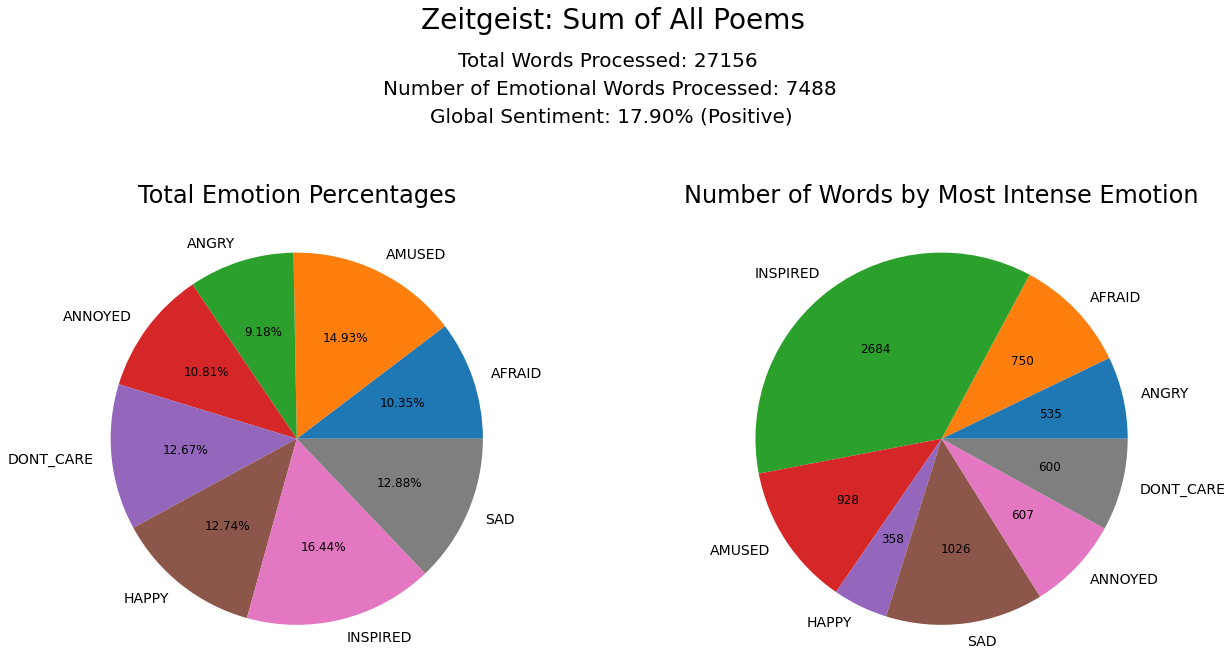

In [11]:

import matplotlib.pyplot as plt

# Gather the emotion values and keys
emotion_values = zeitgeist["emotions"].values()
emotion_keys = zeitgeist["emotions"].keys()

# Gather the keys and values of the number of words per emotion
word_values = zeitgeist["words_by_emotion"].values()
word_keys = zeitgeist["words_by_emotion"].keys()

# Create the subplot. 1,2 denotes 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to the two pies

# Create the pies for the subplot
add_pie(ax1, emotion_values, emotion_keys, "Total Emotion Percentages", 2)
add_pie(ax2, word_values, word_keys, "Number of Words by Most Intense Emotion", 2, lambda val: '{:.0f}'.format(val * sum(word_values) / 100))

# Select the tight layout display
plt.tight_layout()

# Set the whole plot title, and several subtitles
plot_title = plt.suptitle("Zeitgeist: Sum of All Poems", y=0.8, size=28)
plot_text = plt.text(x=-5.2, y=4, s="Total Words Processed: " + str(zeitgeist["total_words_processed"]), fontdict={'fontsize': 20})
plot_text = plt.text(x=-6, y=3.7, s="Number of Emotional Words Processed: " + str(zeitgeist["total_nbr_of_emotional_words"]), fontdict={'fontsize': 20})
plot_text = plt.text(x=-5.5, y=3.4, s="Global Sentiment: " + str('%.2f'%(zeitgeist["sentiment"] * 100) + "% (Positive)"), fontdict={'fontsize': 20})

### Print total elapsed ms from first cell processing to last

In [12]:
print("Notebook execution took " + str((get_ms_now() - total_elapsed_ms) * 0.001) + " seconds")

Notebook execution took 30.084 seconds
